In [1]:
%matplotlib inline

In [31]:
import os
from utils import *

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix

from numpy.random import random, permutation

import keras
from keras.preprocessing import image

## Load VGG model

In [3]:
import vgg16; reload(vgg16)
from vgg16 import Vgg16

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [6]:
batch_size = 64
basepath = "../../../data/dogscats/"

vgg = Vgg16()
batches = vgg.get_batches(basepath + "train", batch_size = batch_size)
val_batches = vgg.get_batches(basepath + "valid", batch_size = batch_size)
vgg.finetune(batches)
vgg.fit(batches = batches, val_batches = val_batches, nb_epoch = 1)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/1
23000/23000 [==============================] - 586s - loss: 0.1278 - acc: 0.9670 - val_loss: 0.0670 - val_acc: 0.9810


In [7]:
vgg.fit(batches = batches, val_batches = val_batches, nb_epoch = 1)

Epoch 1/1
23000/23000 [==============================] - 587s - loss: 0.0957 - acc: 0.9775 - val_loss: 0.0745 - val_acc: 0.9820


## Test VGG model

In [18]:
model_path = basepath + "models/"

if not os.path.isdir(model_path):
    os.mkdir(model_path)

In [10]:
## FUNCTIONS FOR SAVING AND LOADING DATA AS NUMPY ARRAYS
import bcolz
def save_array(fname, arr):
    c = bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()
    
def load_array(fname):
    return bcolz.open(fname)[:]

In [15]:
val_data = get_data(basepath + "valid")

Found 2000 images belonging to 2 classes.


In [16]:
trn_data = get_data(basepath + "train")

Found 23000 images belonging to 2 classes.


In [19]:
## save data to disk
save_array(model_path + "val_data.bc", val_data)
save_array(model_path + "trn_data.bc", trn_data)

In [ ]:
## load data from disk
val_data = load_array(model_path + "val_data.bc")
trn_data = load_array(model_path + "trn_data.bc")

In [22]:
## get classes in order
batches = vgg.get_batches(basepath + "train", shuffle = False, batch_size = 1)
val_batches = vgg.get_batches(basepath + "valid", shuffle = False, batch_size = 1)

def onehot(x):
    return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())

val_classes = val_batches.classes
trn_classes = batches.classes
val_labels = onehot(val_classes)
trn_labels = onehot(trn_classes)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [24]:
trn_labels.shape

(23000, 2)

###  Viewing model prediction examples

Keras' *fit()* function conveniently shows us the value of the loss function, and the accuracy, after every epoch ("*epoch*" refers to one full run through all training examples). The most important metrics for us to look at are for the validation set, since we want to check for over-fitting. 

- **Tip**: with our first model we should try to overfit before we start worrying about how to handle that - there's no point even thinking about regularization, data augmentation, etc if you're still under-fitting! (We'll be looking at these techniques shortly).

As well as looking at the overall metrics, it's also a good idea to look at examples of each of:
1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (ie those with highest probability that are correct)
4. The most incorrect labels of each class (ie those with highest probability that are incorrect)
5. The most uncertain labels (ie those with probability closest to 0.5).

Let's see what we, if anything, we can from these (in general, these are particularly useful for debugging problems in the model; since this model is so simple, there may not be too much to learn at this stage.)

In [26]:
## predict classes
preds = vgg.model.predict_classes(val_data, batch_size = batch_size)

probs = vgg.model.predict_proba(val_data, batch_size = batch_size)[:,0]
probs[:8]

2000/2000 [==============================] - 46s    


array([ 0.9986,  1.    ,  0.5899,  1.    ,  1.    ,  1.    ,  1.    ,  1.    ], dtype=float32)

In [27]:
preds[:8]

array([0, 0, 0, 0, 0, 0, 0, 0])

#### view a selection of validation images

In [28]:
filenames = val_batches.filenames

In [34]:
def plots_idx(idx, titles=None):
    plots([image.load_img(basepath + "valid/" + filenames[i]) for i in idx], titles = titles)

In [32]:
n_view = 4

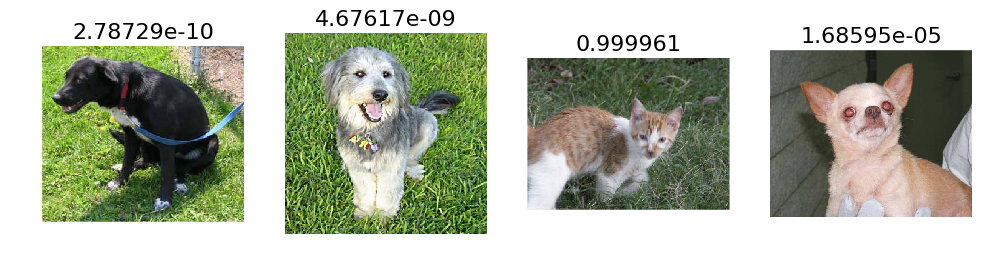

In [35]:
## plot random selection of correct 
correct = np.where(preds == val_labels[:,1])[0]
idx = permutation(correct)[:n_view]
plots_idx(idx, probs[idx])

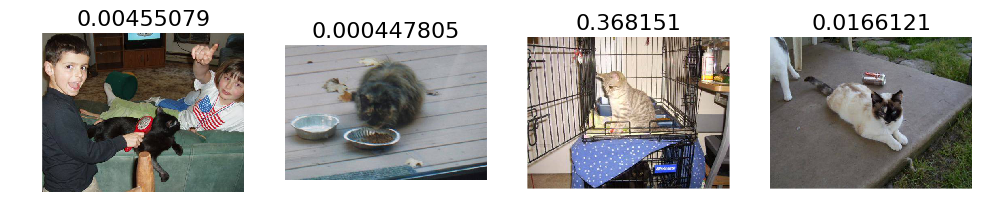

In [36]:
## plot random selection of incorrect 
incorrect = np.where(preds != val_labels[:,1])[0]
idx = permutation(incorrect)[:n_view]
plots_idx(idx, probs[idx])

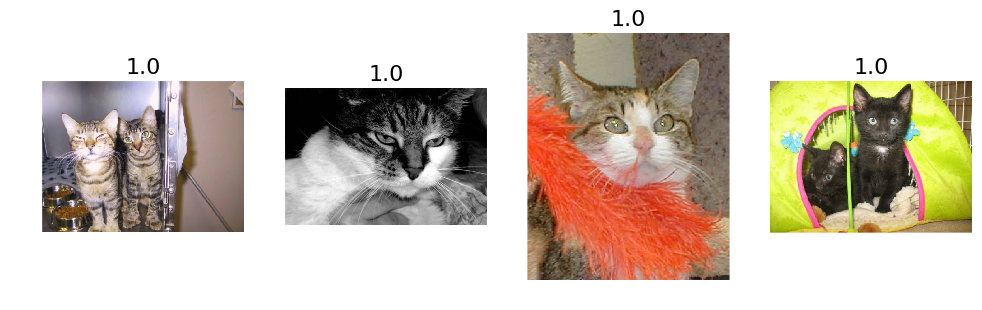

In [55]:
## plot random selection of most correct cats
correct_cats = np.where((preds == 0) & (preds == val_labels[:,1]))[0]
idx = np.argsort(probs[correct_cats])[::-1][:n_view]
plots_idx(correct_cats[idx], probs[correct_cats][idx])

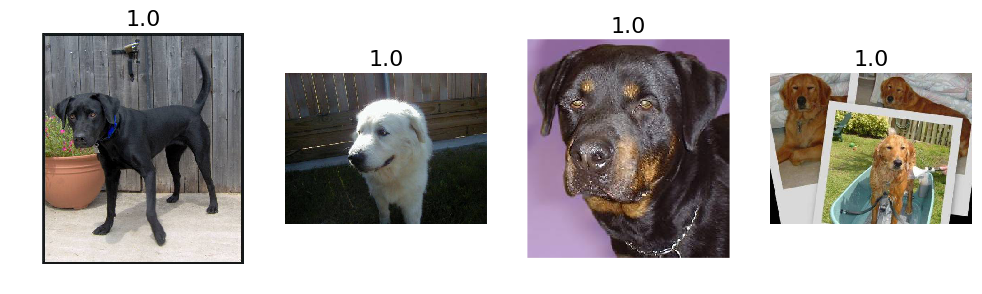

In [57]:
## plot random selection of most correct dogs
correct_dogs = np.where((preds == 1) & (preds == val_labels[:,1]))[0]
idx = np.argsort(probs[correct_dogs])[:n_view]
plots_idx(correct_dogs[idx], 1-probs[correct_dogs][idx])

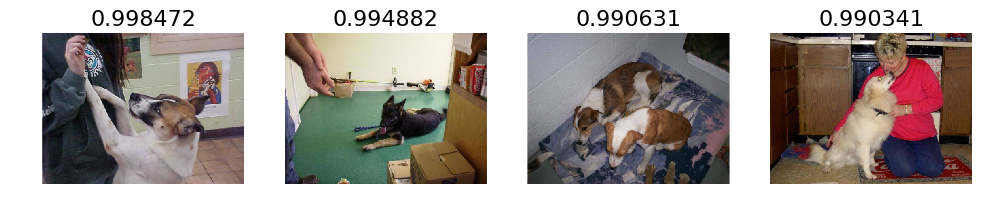

In [58]:
## plot random selection of most imcorrect cats
incorrect_cats = np.where((preds == 0) & (preds != val_labels[:,1]))[0]
idx = np.argsort(probs[incorrect_cats])[::-1][:n_view]
plots_idx(incorrect_cats[idx], probs[incorrect_cats][idx])

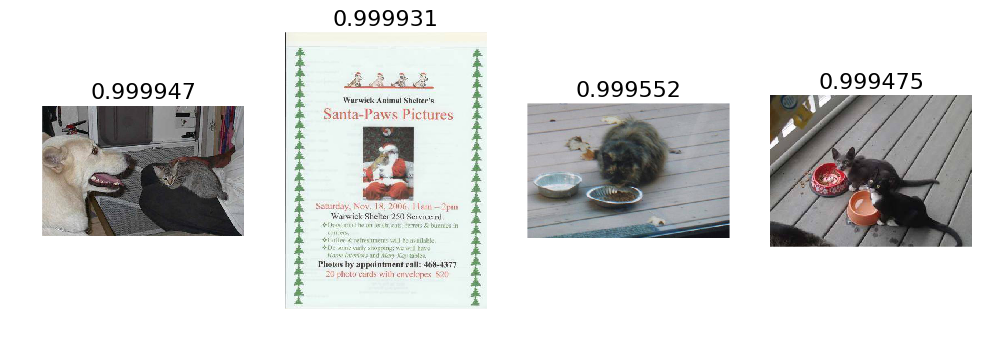

In [60]:
## plot random selection of most correct dogs
incorrect_dogs = np.where((preds == 1) & (preds != val_labels[:,1]))[0]
idx = np.argsort(probs[incorrect_dogs])[:n_view]
plots_idx(incorrect_dogs[idx], 1-probs[incorrect_dogs][idx])

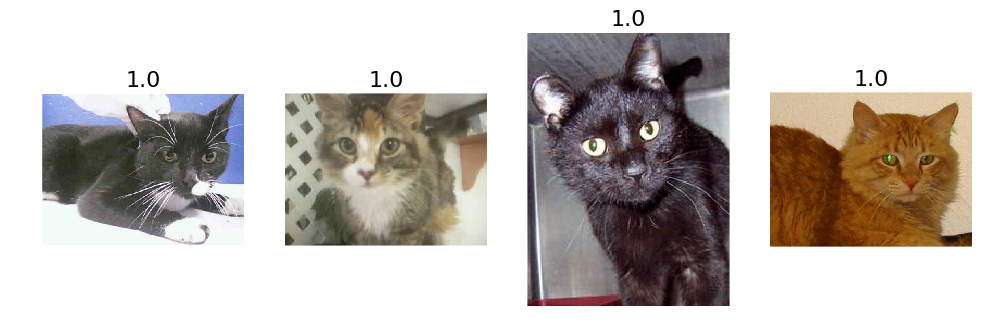

In [46]:
## plot random selection of most incorrect 
idx = np.argsort(np.abs(probs[incorrect] - val_labels[incorrect,1]))[::-1][:n_view]
plots_idx(idx, probs[idx])

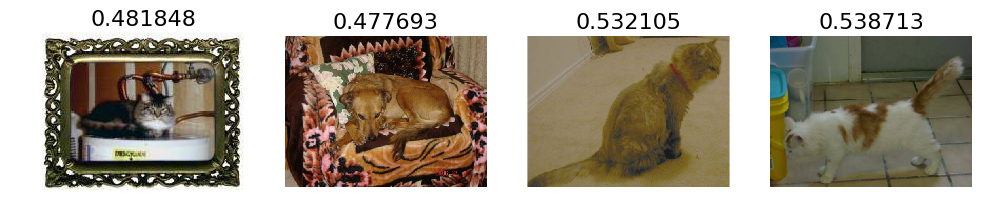

In [62]:
## plot random selection of most uncertain
uncertain = np.argsort(np.abs(probs - 0.5))[:n_view]
plots_idx(uncertain, probs[uncertain])

In [63]:
cm = confusion_matrix(val_classes, preds)

[[977  23]
 [ 10 990]]


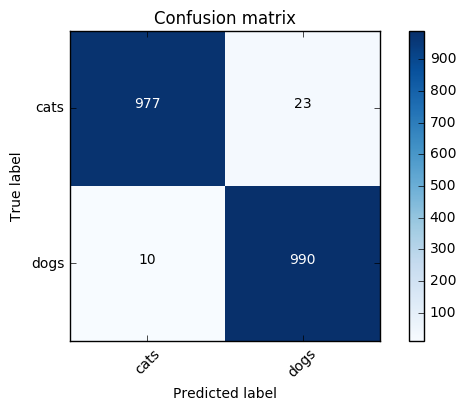

In [64]:
plot_confusion_matrix(cm, val_batches.class_indices)

In [44]:
val_labels[31,1]

0.0

In [47]:
preds[31]

1

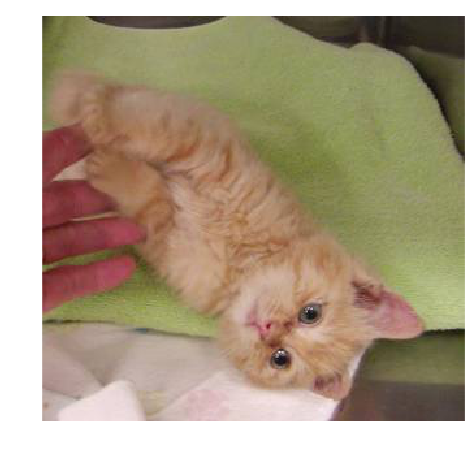

In [48]:
plots_idx([31])

In [49]:
val_classes[31]

0

In [51]:
val_classes[1000]

1

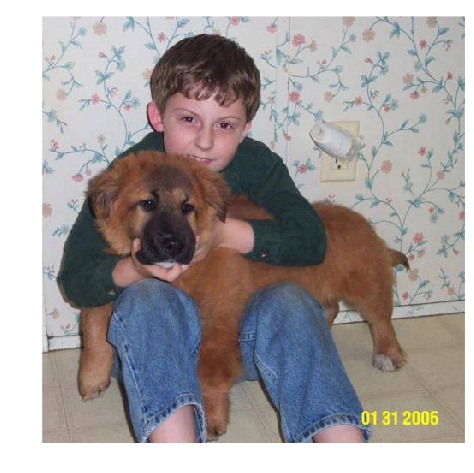

In [52]:
plots_idx([1000])

In [54]:
preds[:5]

array([0, 0, 0, 0, 0])